## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# one-hot encoder
from sklearn.preprocessing import OneHotEncoder

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc.) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
vars_num = [var for var in data.columns if data[var].dtype == 'float']

vars_cat = [var for var in data.columns if data[var].dtype == 'O']
vars_cat += ['pclass', 'sibsp', 'parch']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 2
Number of categorical variables: 7


### Find missing values in variables

In [11]:
# first in numerical variables
data[vars_num].isna().sum()

age     263
fare      1
dtype: int64

In [12]:
# now in categorical variables
data[vars_cat].isna().sum()

sex            0
cabin       1014
embarked       2
title          0
pclass         0
sibsp          0
parch          0
dtype: int64

### Determine cardinality of categorical variables

In [13]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
pclass        3
sibsp         7
parch         8
dtype: int64

### Determine the distribution of numerical variables

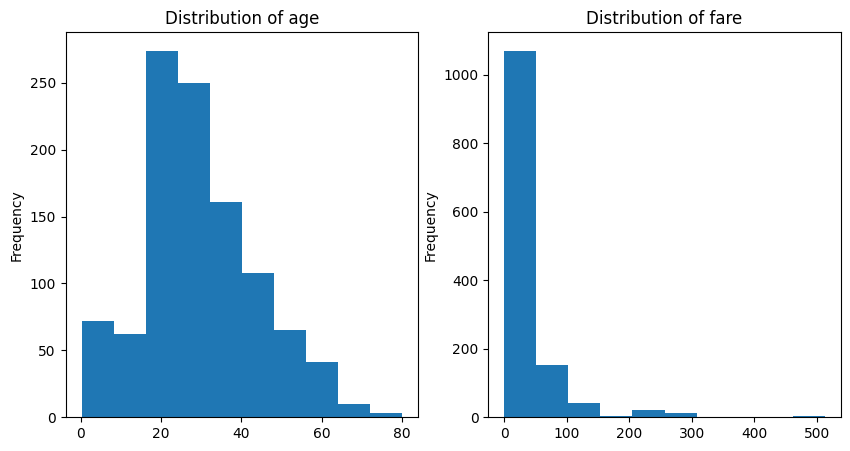

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
for var, ax in zip(vars_num, axes.ravel()):
    data[var].plot(kind='hist', ax=ax)
    ax.set_title(f'Distribution of {var}')
plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [16]:
X_train['cabin'] = X_train['cabin'].str[0]
X_test['cabin'] = X_test['cabin'].str[0]

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [17]:
for var in vars_num:
    colname = f'{var}_missing'
    X_train[colname] = np.where(X_train[var].isna(), 1, 0)
    X_test[colname] = np.where(X_test[var].isna(), 1, 0)
    X_train[var].fillna(X_train[var].median(), inplace=True)
    X_test[var].fillna(X_test[var].median(), inplace=True)

### Replace Missing data in categorical variables with the string **Missing**

In [18]:
X_train[vars_cat].fillna('Missing', inplace=True)
X_test[vars_cat].fillna('Missing', inplace=True)

/home/kiko/Learning/Deployment_of_ML_models/deploying-machine-learning-models/venv/lib/python3.8/site-packages/pandas/core/frame.py:4459: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [19]:
def rare_categories(X_train, var, threshold=0.05):
    tmp = X_train[var].value_counts(normalize=True)
    rare = tmp[tmp < threshold].index.tolist()

    return rare

In [20]:
for var in vars_cat:
    rare = rare_categories(X_train, var)
    X_train[var] = np.where(X_train[var].isin(rare), 'Rare', X_train[var])
    X_test[var] = np.where(X_test[var].isin(rare), 'Rare', X_test[var])
    print(X_train[var].value_counts(normalize=True))
    print(X_test[var].value_counts(normalize=True))

male      0.633238
female    0.366762
Name: sex, dtype: float64
male      0.687023
female    0.312977
Name: sex, dtype: float64
C       0.319672
B       0.213115
D       0.147541
E       0.147541
A       0.077869
F       0.073770
Rare    0.020492
Name: cabin, dtype: float64
C       0.313725
B       0.254902
D       0.196078
E       0.098039
F       0.058824
A       0.058824
Rare    0.019608
Name: cabin, dtype: float64
S    0.711005
C    0.196172
Q    0.092823
Name: embarked, dtype: float64
S    0.652672
C    0.248092
Q    0.099237
Name: embarked, dtype: float64
Mr      0.569245
Miss    0.200573
Mrs     0.159503
Rare    0.070678
Name: title, dtype: float64
Mr      0.618321
Miss    0.183206
Mrs     0.129771
Rare    0.068702
Name: title, dtype: float64
3    0.546323
1    0.249284
2    0.204394
Name: pclass, dtype: float64
3    0.522901
2    0.240458
1    0.236641
Name: pclass, dtype: float64
0       0.671442
1       0.249284
Rare    0.079274
Name: sibsp, dtype: float64
0       0.717557
1 

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [23]:
enc = OneHotEncoder(drop='first').fit(X_train[vars_cat])
enc_cols = enc.get_feature_names(vars_cat)
X_train[enc_cols] = enc.transform(X_train[vars_cat]).todense()
X_test[enc_cols] = enc.transform(X_test[vars_cat]).todense()
X_train.drop(vars_cat, inplace=True, axis=1)
X_test.drop(vars_cat, inplace=True, axis=1)
X_train

,age,fare,age_missing,fare_missing,sex_male,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_Rare,cabin_nan,embarked_Q,embarked_S,embarked_nan,title_Mr,title_Mrs,title_Rare,pclass_2,pclass_3,sibsp_1,sibsp_Rare,parch_1,parch_2,parch_Rare
1118,25.0000,7.9250,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
44,41.0000,134.5000,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1072,28.0000,7.7333,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1130,18.0000,7.7750,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
574,29.0000,21.0000,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.1667,20.5750,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
835,28.0000,8.0500,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1216,28.0000,7.7333,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
559,20.0000,36.7500,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Scale the variables

- Use the standard scaler from Scikit-learn

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [25]:
clf = LogisticRegression(random_state=0, C=0.0005)
clf.fit(X_train, y_train)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [26]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

In [27]:
y_pred_proba[:, 1]

array([0.3006944 , 0.45115844, 0.34484829, 0.29142343, 0.33685076,
       0.45548643, 0.38460769, 0.42156029, 0.3290039 , 0.2903624 ,
       0.33614766, 0.32006663, 0.41929624, 0.39760498, 0.54302113,
       0.33322547, 0.50396134, 0.37063901, 0.48094844, 0.30139241,
       0.30273757, 0.34694773, 0.30203191, 0.52940837, 0.40141188,
       0.47101826, 0.33393531, 0.31564215, 0.30530353, 0.39783349,
       0.43478395, 0.53351163, 0.47958268, 0.36806433, 0.55116652,
       0.29027322, 0.30136626, 0.33210991, 0.30446322, 0.30260396,
       0.2902193 , 0.3317437 , 0.421632  , 0.41976682, 0.40820516,
       0.36142111, 0.31545748, 0.57166741, 0.38900011, 0.29046197,
       0.43168917, 0.29032507, 0.30257776, 0.42691346, 0.30233449,
       0.29035203, 0.55142779, 0.4484678 , 0.41236761, 0.44879291,
       0.30339004, 0.44069087, 0.39049399, 0.40125844, 0.39155848,
       0.46246088, 0.33367294, 0.30446322, 0.30298717, 0.41301198,
       0.48095806, 0.3009541 , 0.37475416, 0.29892696, 0.39790

In [28]:
accuracy_score(y_test, y_pred)

0.7061068702290076

In [29]:
roc_auc_score(y_test, y_pred_proba[:, 1])

0.8366358024691358

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**

In [30]:
joblib.dump(clf, 'logistic_regression.joblib')

['logistic_regression.joblib']